In [2]:
import os
import numpy as np
import cv2

In [3]:
def crop_image_and_label(img, label_file):
    min_x, max_x, min_y, max_y = 0, 1913, 543, 1139

    original_width, original_height = 1920, 1208

    cropped_width = max_x - min_x
    cropped_height = max_y - min_y

    cropped = img[min_y:max_y, min_x:max_x]

    new_label = []
    poles = get_poles(label_file)
    for x_norm, y_norm, w_norm, h_norm in poles:
        x_pix = x_norm * original_width
        y_pix = y_norm * original_height
        w_pix = w_norm * original_width
        h_pix = h_norm * original_height

        x_pix_cropped = x_pix - min_x
        y_pix_cropped = y_pix - min_y


        x_norm_cropped = x_pix_cropped / cropped_width
        y_norm_cropped = y_pix_cropped / cropped_height
        w_norm_cropped = w_pix / cropped_width
        h_norm_cropped = h_pix / cropped_height

        new_label.append(f"0 {x_norm_cropped:.6f} {y_norm_cropped:.6f} {w_norm_cropped:.6f} {h_norm_cropped:.6f}\n")

    return cropped, new_label


In [4]:
def crop_image_only(img):
    min_x, max_x, min_y, max_y = 0, 1913, 543, 1139
    cropped = img[min_y:max_y, min_x:max_x]
    return cropped


In [5]:
def z_score_norm(img):
    mean = np.mean(img)
    std = np.std(img)
    zscore_img = (img - mean) / std

    zscore_rescaled = ((zscore_img - zscore_img.min()) / (zscore_img.max() - zscore_img.min()) * 255).astype(np.uint8)
    return zscore_rescaled

In [6]:

def get_poles(pole_files):
    poles = []
    with open(pole_files, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                cls, x_center, y_center, w_norm, h_norm = map(float, parts)
                poles.append((x_center, y_center, w_norm, h_norm))
    return poles

In [132]:
img_file = "../dataset/roadpoles_v1/train/images/frame_000010.PNG"
label_file = "../dataset/roadpoles_v1/train/labels/frame_000010.txt"

save_prefix = "_cropped"

img = cv2.imread(img_file)
crop_img, new_label = crop_image_and_label(img, label_file)



img_dir, img_name = os.path.split(img_file)
base_name, ext = os.path.splitext(img_name)
cropped_img_file = os.path.join(img_dir, base_name + save_prefix + ext)
cv2.imwrite(cropped_img_file, crop_img)
lab_dir, lab_name = os.path.split(label_file)
base_name, ext = os.path.splitext(lab_name)
cropped_label_file = os.path.join(lab_dir, base_name + save_prefix + ext)
with open(cropped_label_file, "w") as f:
    f.writelines(new_label)


In [7]:
base_data_path = "..\\dataset\\roadpoles_v1\\valid"

imagesTr = os.path.join(base_data_path, "images")
labelsTr = os.path.join(base_data_path, "labels")

train_images = sorted([os.path.join(imagesTr, f) for f in os.listdir(imagesTr) if f.endswith(".PNG")])
train_labels = sorted([os.path.join(labelsTr, f) for f in os.listdir(labelsTr) if f.endswith(".txt")])

train_data = [{"image": img, "label": lbl} for img, lbl in zip(train_images, train_labels)]

preprocessed_data = []

for td in train_data:
    img = cv2.imread(td["image"])
    label = td["label"]

    cropped, new_label = crop_image_and_label(img, label)  # use `label`, not `label_file`
    z_score_normalized_img = z_score_norm(cropped)

    preprocessed_data.append({"image": z_score_normalized_img, "label": new_label})


In [8]:
from matplotlib import pyplot as plt
import cv2

def viz_example(image, test_label):
    # image is already a NumPy array (RGB or BGR)
    if image.shape[2] == 3:  # if BGR, convert to RGB for plotting
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        rgb_image = image  # grayscale or already RGB

    height, width, _ = rgb_image.shape
    print("image shape:", rgb_image.shape)

    boxes = []
    for line in test_label:
        parts = line.strip().split()
        if len(parts) == 5:
            cls, x_center, y_center, w_norm, h_norm = map(float, parts)
            x_center_pix = x_center * width
            y_center_pix = y_center * height
            w_pix = w_norm * width
            h_pix = h_norm * height
            boxes.append((x_center_pix, y_center_pix, w_pix, h_pix))

    for x, y, w, h in boxes:
        top_left = (int(x - w/2), int(y - h/2))
        bottom_right = (int(x + w/2), int(y + h/2))
        cv2.rectangle(rgb_image, top_left, bottom_right, (255, 0, 0), 2)
        cv2.circle(rgb_image, (int(x), int(y)), 3, (0, 255, 0), -1)

    plt.figure(figsize=(12, 8))
    plt.imshow(rgb_image)
    plt.axis("off")
    plt.show()


image shape: (596, 1913, 3)


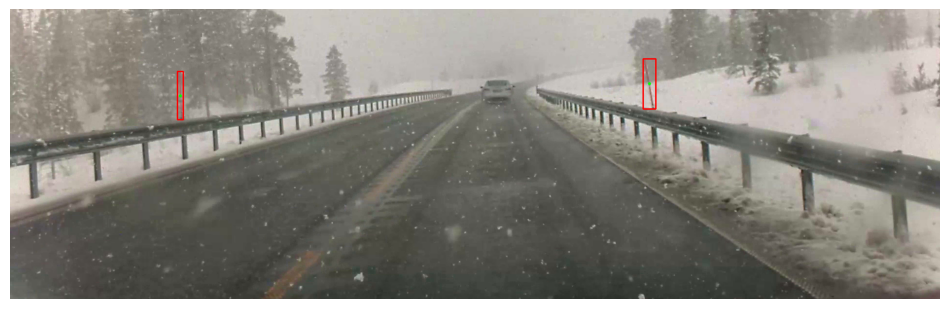

In [135]:
image = preprocessed_data[0]["image"]
label = preprocessed_data[0]["label"]

viz_example(image, label)

In [10]:
import os
import cv2

# Set up output directories
output_base = "..\\dataset\\roadpoles_v1\\valid_preprocessed"
images_out = os.path.join(output_base, "images")
labels_out = os.path.join(output_base, "labels")

os.makedirs(images_out, exist_ok=True)
os.makedirs(labels_out, exist_ok=True)

# Loop over preprocessed data and save
for idx, data in enumerate(preprocessed_data):
    img = data["image"]
    label = data["label"]

    # Get original filename to keep consistent names
    orig_img_path = train_data[idx]["image"]
    orig_label_path = train_data[idx]["label"]
    img_name = os.path.basename(orig_img_path)
    label_name = os.path.basename(orig_label_path)

    # Save image
    # If images are z-score normalized, scale to 0-255 and convert to uint8
    img_to_save = ((img - img.min()) / (img.max() - img.min()) * 255).astype("uint8")
    cv2.imwrite(os.path.join(images_out, img_name), img_to_save)

    # Save label
    with open(os.path.join(labels_out, label_name), "w") as f:
        f.writelines(label)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [13]:
import os
import cv2

base_data_path = "..\\dataset\\roadpoles_v1\\test"
images_path = os.path.join(base_data_path, "images")

# Get all PNG images
image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith(".PNG")])

# Folder to save preprocessed images
output_base = "..\\dataset\\roadpoles_v1\\test_preprocessed"
images_out = os.path.join(output_base, "images")
os.makedirs(images_out, exist_ok=True)

preprocessed_data = []

for img_file in image_files:
    img = cv2.imread(img_file)

    # Crop only (make sure you have this function)
    cropped = crop_image_only(img)

    # Z-score normalization
    z_score_normalized_img = z_score_norm(cropped)


    # Save image
    img_name = os.path.basename(img_file)
    save_path = os.path.join(images_out, img_name)
    cv2.imwrite(save_path, img_to_save)

    # Store in memory
    preprocessed_data.append(img_to_save)

print(f"Saved {len(preprocessed_data)} images to {images_out}")


Saved 46 images to ..\dataset\roadpoles_v1\test_preprocessed\images


In [11]:
import os
import cv2

base_data_path = "..\\dataset\\roadpoles_v1\\valid"

imagesTr = os.path.join(base_data_path, "images")
labelsTr = os.path.join(base_data_path, "labels")

# Collect image and label paths
train_images = sorted([os.path.join(imagesTr, f) for f in os.listdir(imagesTr) if f.endswith(".PNG")])
train_labels = sorted([os.path.join(labelsTr, f) for f in os.listdir(labelsTr) if f.endswith(".txt")])

train_data = [{"image": img, "label": lbl} for img, lbl in zip(train_images, train_labels)]

# Output directories
output_base = "..\\dataset\\roadpoles_v1\\valid_preprocessed"
images_out = os.path.join(output_base, "images")
labels_out = os.path.join(output_base, "labels")

os.makedirs(images_out, exist_ok=True)
os.makedirs(labels_out, exist_ok=True)

preprocessed_data = []

for td in train_data:
    img = cv2.imread(td["image"])
    label = td["label"]

    # Crop image and label
    cropped, new_label = crop_image_and_label(img, label)

    # Z-score normalization
    z_score_normalized_img = z_score_norm(cropped)

    # Add to in-memory list
    preprocessed_data.append({"image": z_score_normalized_img, "label": new_label})

    # --- Save preprocessed image ---
    img_name = os.path.basename(td["image"])
    img_to_save = ((z_score_normalized_img - z_score_normalized_img.min()) /
                   (z_score_normalized_img.max() - z_score_normalized_img.min()) * 255).astype("uint8")
    cv2.imwrite(os.path.join(images_out, img_name), img_to_save)

    # --- Save corresponding label ---
    label_name = os.path.basename(td["label"])
    label_save_path = os.path.join(labels_out, label_name)
    with open(label_save_path, "w") as f:
        f.writelines(new_label)

print(f"✅ Saved {len(preprocessed_data)} preprocessed images to '{images_out}' and labels to '{labels_out}'")


✅ Saved 92 preprocessed images to '..\dataset\roadpoles_v1\valid_preprocessed\images' and labels to '..\dataset\roadpoles_v1\valid_preprocessed\labels'
